In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from itertools import cycle, islice
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
import gc

C:\Users\Manik\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_file_name = 'drugsComTrain_raw.csv'
test_file_name = 'drugsComTest_raw.csv'
file_path = './data/'

df_test = pd.read_csv(file_path+test_file_name)
df_train = pd.read_csv(file_path+train_file_name)

In [3]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


## Top five conditions

In [5]:
df_train['condition'].value_counts().sort_values(ascending=False)[0:5]

Birth Control    28788
Depression        9069
Pain              6145
Anxiety           5904
Acne              5588
Name: condition, dtype: int64

C:\Users\Manik\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


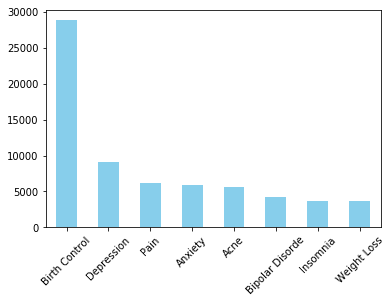

In [6]:
bar_data = df_train['condition'].value_counts().sort_values(ascending=False)[0:8]
# my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(bar_data)))
ax = bar_data.plot.bar(color='skyblue',stacked=True)
plt.xticks(rotation=45)
plt.axes(ax)
plt.show()

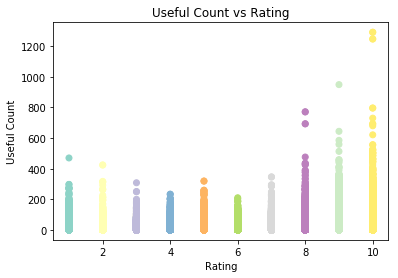

In [7]:
plt.scatter(df_train['rating'], df_train['usefulCount'], c=df_train['rating'].values, cmap='Set3')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.show()

In [16]:
vader_analyzer = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = vader_analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [17]:
sentiments = []
for i in df_train.review:
    sentiments.append(vader_analyzer.polarity_scores(i))
    
sentiments = np.asarray(sentiments)

In [8]:
print(df_train.review[10])
print(sentiments[10])
print(df_train.rating[10])

"I have been on this medication almost two weeks, started out on 25mg and working my way up to 100mg, currently at 50mg. No headaches at all so far and I was having 2-3 crippling migraines a week. I have lost 5.2lbs so far but note I am really paying close attention to what I am eating, I have a lot of weight to lose and if weight loss is a side effect I want to help it along as much as I can.  Now, other side effects, they are there the word recall issues exist, the memory issues, the worst of it seems to be the vision disturbances, there have been times I have just not driven because I&#039;m sure it would not have been safe. The good news is it seems to be wearing off...I have tons of energy and I am in a great mood."


NameError: name 'sentiments' is not defined

In [9]:
# Creates TF-IDF vectorizer and transforms the corpus
# vectorizer = TfidfVectorizer()
vectorizer = HashingVectorizer(n_features=2**13)
X_train = vectorizer.fit_transform(df_train.review)

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(df_test.review)

In [10]:
gc.collect()

2117

In [20]:
print(X_train[0].shape)
print(X_train.shape)
print(X_train[2].shape)
print(X_train[3].shape)

y_train = df_train.rating
y_test = df_test.rating
print()

print(type(y_train))
print(y_train.shape)
print(type(y_test))
print(y_test.shape)

print()

print(max(y_train))
print(max(y_test))
print()
print(min(y_train))
print(min(y_test))

(1, 8192)
(161297, 8192)
(1, 8192)
(1, 8192)

<class 'pandas.core.series.Series'>
(161297,)
<class 'pandas.core.series.Series'>
(53766,)

10
10

1
1


In [21]:
x_train_nn = X_train
x_test_nn = X_test
y_train_nn = keras.utils.to_categorical(np.array(y_train))
y_test_nn = keras.utils.to_categorical(np.array(y_test))

In [24]:
y_train = df_train.rating.copy(deep=True)
y_test = df_test.rating.copy(deep=True)

def conver_op(labels):
    for i in range(len(labels)):
        if(labels[i]<3):
            labels[i]=0
        elif(labels[i]<7):
            labels[i]=1
        elif(labels[i]<=10):
            labels[i]=2
    return labels

# y_train = conver_op(y_train)
# y_test = conver_op(y_test)

In [22]:
print(x_train_nn.shape)
print(y_train_nn.shape)
print(x_test_nn.shape)
print(y_test_nn.shape)
print()
print(x_train_nn[0])
print(y_train_nn[0])

(161297, 8192)
(161297, 11)
(53766, 8192)
(53766, 11)

  (0, 301)	-0.24253562503633297
  (0, 447)	-0.24253562503633297
  (0, 1297)	0.24253562503633297
  (0, 1646)	0.24253562503633297
  (0, 2110)	0.48507125007266594
  (0, 2191)	0.24253562503633297
  (0, 4395)	-0.24253562503633297
  (0, 4396)	0.24253562503633297
  (0, 4952)	-0.24253562503633297
  (0, 4972)	0.24253562503633297
  (0, 5552)	0.24253562503633297
  (0, 6020)	-0.24253562503633297
  (0, 6711)	-0.24253562503633297
  (0, 7625)	-0.24253562503633297
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [25]:
y_train

0          9
1          8
2          5
3          8
4          9
          ..
161292    10
161293     1
161294     2
161295    10
161296     9
Name: rating, Length: 161297, dtype: int64

In [26]:
%%time
# vectorizer.get_feature_names()
rfc_rating = RandomForestClassifier(n_estimators=20, random_state=42, max_depth = 500, min_samples_split = 0.001, verbose=2)
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
pred = rfc_rating.predict(X_test)

print("Accuracy: %s" % str(rfc_rating.score(X_test, y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy: 0.43553546851169883
Confusion Matrix
[[ 4031   643   527   282   344   200   177   191   181   209]
 [    0    23     1     0     0     0     0     0     0     0]
 [    0     1    28     0     1     0     0     0     0     0]
 [    0     0     0    17     0     0     0     0     1     0]
 [    0     0     0     0    48     0     0     0     0     0]
 [    0     1     1     0     1    32     0     0     0     1]
 [    0     0     0     0     0     1    56     2     0     0]
 [   12    14    35    29    32    39    63   667    30    15]
 [  105    98   110   125   220   186   261   334  1885   161]
 [ 3151  1554  1503  1206  2064  1661  2534  4962  7080 16630]]
Wall time: 1min 46s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.2s finished


In [36]:
import sklearn
print("Accuracy : {}%".format(round(sklearn.metrics.accuracy_score(pred, y_test) * 100, 2)))

Accuracy : 43.55%


In [23]:
# print(len(vectorizer.get_feature_names()))
# vectorizer.get_feature_names()[6000:7000]

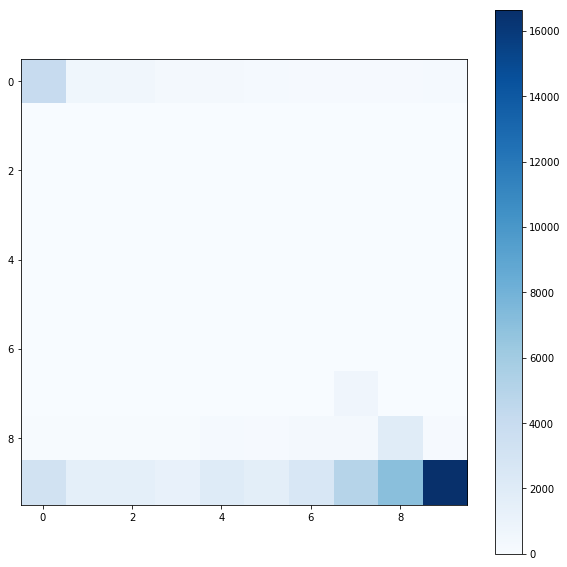

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(pred, y_test)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
plt.show()

In [99]:
model = Sequential()

# Dense-1
model.add(Dense(500, input_shape=(8192,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Dense-2
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Dense-3
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [100]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               4096500   
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
activation_3 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               150300    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation_4 (Activation)    (None, 300)               0         
__________

In [101]:
model_history = model.fit(x_train_nn, y_train_nn, epochs=20, batch_size=256, validation_data=(x_test_nn, y_test_nn))

Train on 161297 samples, validate on 53766 samples
Epoch 1/20
161297/161297 [==============================] - 140s 870us/step - loss: 0.6313 - acc: 0.7438 - val_loss: 0.5362 - val_acc: 0.7771
Epoch 2/20
161297/161297 [==============================] - 139s 861us/step - loss: 0.4974 - acc: 0.7950 - val_loss: 0.4977 - val_acc: 0.7971
Epoch 3/20
161297/161297 [==============================] - 137s 851us/step - loss: 0.4206 - acc: 0.8285 - val_loss: 0.4651 - val_acc: 0.8139
Epoch 4/20
161297/161297 [==============================] - 139s 863us/step - loss: 0.3435 - acc: 0.8635 - val_loss: 0.4346 - val_acc: 0.8328
Epoch 5/20
161297/161297 [==============================] - 137s 852us/step - loss: 0.2724 - acc: 0.8942 - val_loss: 0.4055 - val_acc: 0.8572
Epoch 6/20
161297/161297 [==============================] - 138s 855us/step - loss: 0.2210 - acc: 0.9152 - val_loss: 0.3998 - val_acc: 0.8724
Epoch 7/20
161297/161297 [==============================] - 137s 850us/step - loss: 0.1773 - acc:

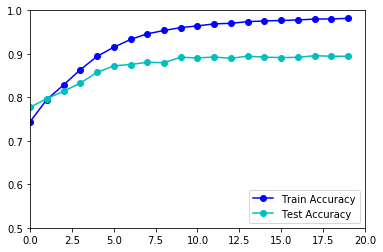

In [108]:
acc = model_history.history['acc']
val = model_history.history['val_acc']
epochs = 20

plt.plot(range(epochs), acc, 'ob-', label='Train Accuracy')
plt.plot(range(epochs), val, 'oc-', label='Test Accuracy')
plt.legend(loc='lower right')
plt.xlim(0, 20)
plt.ylim(0.5, 1)
plt.show()

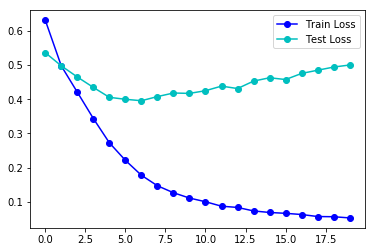

In [110]:
loss = model_history.history['loss']
vall = model_history.history['val_loss']
epochs = 20

plt.plot(range(epochs), loss, 'ob-', label='Train Loss')
plt.plot(range(epochs), vall, 'oc-', label='Test Loss')
plt.legend(loc='upper right')
plt.show()